In [ ]:
!pip install pyedflib

     |████████████████████████████████| 1.2MB 6.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyedflib: filename=pyEDFlib-0.1.20-cp36-cp36m-linux_x86_64.whl size=928459 sha256=0861d8e7bd6f430632dab740493050fda1134e58c3c09cb9a6ac63d3cde43843
  Stored in directory: /root/.cache/pip/wheels/0d/be/b5/574f8b99ad9ac2ecf78e0c5271040b5aff999febfe655b97a4
Successfully built pyedflib


In [ ]:
import numpy as np
import pyedflib as edf
import os
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from scipy.signal import butter, lfilter, iirnotch, filtfilt, sosfilt
import subprocess as sp
import math
import time

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
DOWNLOAD_PATH = "/content/downloaded/"

if not os.path.exists(DOWNLOAD_PATH):
  os.mkdir(DOWNLOAD_PATH)

In [ ]:
#for downloading files
def download_files(patient_num, file_num_list):
  for file_num in file_num_list:
    file_name = f'chb{str(patient_num).zfill(2)}_{str(file_num).zfill(2)}.edf'
    url = f'https://physionet.org/static/published-projects/chbmit/1.0.0/chb{str(patient_num).zfill(2)}/'+file_name
    response_code = sp.call(['wget', url])
    if(response_code != 0):
      print(file_name+"  Not found")
    dest_path = DOWNLOAD_PATH + file_name
    response_code = sp.call(['mv', file_name, dest_path])
    if(response_code == 0):
      print("Downloaded "+file_name)

In [ ]:
def calculate_energy(segment):
  sigma = 1
  segment = np.square(segment)
  sum = 0  
  for d in segment:  
    try:
      e_energy = math.exp(- 1 * (d / sigma))                  
    except Exception as e:
      print("Warning, "+e)      
      e_energy = 0
    
    sum += e_energy

  return sum

In [ ]:
def filter_signal(data, level = "none"):
  #removing 50 and 60 HZ  
  b, a = iirnotch(60, 20, 256)
  noise_removed = lfilter(b, a, data)

  b, a = iirnotch(50, 16, 256)
  noise_removed = lfilter(b, a, noise_removed)
  low, high = None, None

  if level == "delta":
    low = 0.5 / (0.5 * 256)
    high = 4 / (0.5 * 256)
  elif level == "theta":
    low = 4 / (0.5 * 256)
    high = 7 / (0.5 * 256)
  elif level == "alpha":
    low = 8 / (0.5 * 256)
    high = 12 / (0.5 * 256)
  elif level == "sigma":
    low = 12 / (0.5 * 256)
    high = 16 / (0.5 * 256)
  elif level == "beta":
    low = 16 / (0.5 * 256)
    high = 30 / (0.5 * 256)
  else:
    low = 0.5 / (0.5 * 256)
    high = 40 / (0.5 * 256)
  
  sos = butter(6, [low, high], btype = "bandpass", output = 'sos')
  filtered = sosfilt(sos, noise_removed)
  return filtered

In [ ]:
def get_windows(data, window_size):
  result = list()
  window_size = window_size * 256
  inc = int(window_size / 5)
  for index in range(0, data.shape[0] - window_size, inc):
    sample = data[index : index + window_size]    
    energy = calculate_energy(sample)
    result.append(energy)
  
  return result, np.median(result)

In [ ]:
#new
def process_data_2(data, channel_num, preictal_interval, window_size):
  #take data 10 mins before start of seizure
  gap = 10 * 60 * 256
  #list of all energy values computed on each window segment across all data
  pre_data_list, inter_data_list = list(), list()
  #list of average energy in data
  avg_pre_list, avg_inter_list = list(), list()

  for item in data:
    files = item[0]
    start_time = item[1] + gap

    sequence = None

    if len(files) == 3:
      temp_inter_1 = edf.EdfReader(DOWNLOAD_PATH+files[0]).readSignal(channel_num)
      temp_inter_2 = edf.EdfReader(DOWNLOAD_PATH+files[1]).readSignal(channel_num)
      temp_pre = edf.EdfReader(DOWNLOAD_PATH+files[2]).readSignal(channel_num)[0: start_time*256]
      sequence = np.concatenate((temp_inter_1, temp_inter_2, temp_pre))
    else:      
      temp_inter = edf.EdfReader(DOWNLOAD_PATH+files[0]).readSignal(channel_num)
      temp_pre = edf.EdfReader(DOWNLOAD_PATH+files[1]).readSignal(channel_num)[0: start_time*256]
      sequence = np.concatenate((temp_inter, temp_pre))
    
    sequence = filter_signal(sequence)
    signal_length = sequence.shape[0]
    
    interval = preictal_interval * 60 * 256
    pre_start = signal_length - interval
    inter_start = pre_start - interval

    interictal, preictal = sequence[inter_start : pre_start], sequence[pre_start:]
    
    preictal_energy, avg_preictal_energy = get_windows(preictal, window_size)
    interictal_energy, avg_interictal_energy = get_windows(interictal, window_size)

    pre_data_list.extend(preictal_energy)
    inter_data_list.extend(interictal_energy)

    avg_pre_list.append(avg_preictal_energy)
    avg_inter_list.append(avg_interictal_energy)
  
  return np.array(pre_data_list), np.array(avg_pre_list), np.array(inter_data_list), np.array(avg_inter_list)

In [ ]:
def save_plot(patient_num, files, channel_num, pre_interval, window_size):
  pre, avg_pre_list, inter, avg_inter_list = process_data_2(files, channel_num, pre_interval, window_size)
  avg_pre = np.average(avg_pre_list)
  avg_inter = np.average(avg_inter_list)

  plt.figure(figsize = (15, 5))

  samples = np.arange(1, pre.shape[0]+1)
  
  plt.scatter(samples, pre, color = 'orange', s = 100)
  plt.scatter(samples, inter, color = 'green', s = 100)

  plt.scatter(samples.shape[0], avg_pre, color = 'red', s = 200)
  plt.scatter(samples.shape[0], avg_inter, color = 'blue', s = 200)

  plt.legend(["preictal", "interictal", "Avg energy preictal", "Avg energy interictal"], loc = "upper right")
  plt.title("Exponentation energy - p"+str(patient_num))

  plot_file = f"trial_plot_file_{patient_num}.png"
  plt.savefig(RESULT_PATH + plot_file, bbox_inches = "tight")
  plt.clf()
  samples = np.arange(1, avg_pre_list.shape[0]+1)

  plt.scatter(samples, avg_pre_list, color = 'orange')
  plt.scatter(samples, avg_inter_list, color = 'green')

  plt.scatter(samples.shape[0]+1, avg_pre, color = 'red', s = 200)
  plt.scatter(samples.shape[0]+1, avg_inter, color = 'blue', s = 200)

  plt.legend(["Avg pre per file", "Avg inter per file", "Avg energy preictal", "Avg energy interictal"], loc = "upper right")
  plt.title("Exponentation energy - p"+str(patient_num))
  plot_file = f"trial_avg_plot_{patient_num}.png"
  plt.savefig(RESULT_PATH + plot_file, bbox_inches = "tight")

  plt.show()

In [ ]:
#log file
def save_log_file(patient_num, channel_num, preictal_interval, window_size, avg_pre, avg_inter, min_window_size, min_channel_num, min_preictal_interval):
  file_name = f"trail_relaxed_log_file_{patient_num}.txt"

  with open(RESULT_PATH + file_name, "w") as f:
    print(f"PATIENT: {patient_num}\nCHANNEL: {channel_num}\nPREICTAL_INTERVAL: {preictal_interval}\nWINDOW_SIZE: {window_size}\nAVG_PRE_ENERGY: {avg_pre}\nAVG_INTER_ENERY: {avg_inter}\nMIN CHANNEL: {min_channel_num}\nMin WINDOW_SIZE: {min_window_size}\nMIN_PREICTAL_INTERVAL: {min_preictal_interval}", file = f)

In [ ]:
def get_best(patient_num, files):
  start = time.time()
  max_diff, best_channel_num, best_window_size, best_pre_interval = None, None, None, None
  min_diff, min_channel_num, min_window_size, min_pre_interval = None, None, None, None
  best_avg_pre, best_avg_inter = None, None

  preictal_intervals = [10, 15, 20, 25, 30]#in mins
  window_sizes = [10, 15] #in secs
  channel_list = np.arange(0, 23)
  
  max_diff = None
  for pre_interval in preictal_intervals:
    for window_size in window_sizes:
      for channel in channel_list:        
        avg_pre_list, pre, avg_inter_list, inter = process_data_2(files, channel, pre_interval, window_size)
        avg_pre, avg_inter = np.average(avg_pre_list), np.average(avg_inter_list)

        diff = abs(avg_pre - avg_inter)
        if max_diff == None or max_diff < diff:
          max_diff = diff
          best_channel_num = channel
          best_pre_interval = pre_interval
          best_window_size = window_size
          best_avg_pre = avg_pre
          best_avg_inter = avg_inter
        
        if min_diff == None or min_diff > diff:
          min_diff = diff
          min_channel_num = channel
          min_pre_interval = pre_interval
          min_window_size = window_size
          

  print(f"Max diff: {max_diff}\tChannel Num: {best_channel_num}\tPreictal Interval: {best_pre_interval}\tWindow Size: {best_window_size}")
  print(f"Min diff: {min_diff}\tChannel Num: {min_channel_num}\tPreictal Interval: {min_pre_interval}\tWindow Size: {min_window_size}")
  print(f"Running time: {time.time() - start} seconds")
  #saving plot and log file
  save_plot(patient_num, files, best_channel_num, best_pre_interval, best_window_size)
  print("Plot file saved")
  save_log_file(patient_num, best_channel_num, best_pre_interval, best_window_size, best_avg_pre, best_avg_inter, min_window_size, min_channel_num, min_pre_interval)  
  print("Log file saved")

##Get data below

In [ ]:
patient_num = 1
RESULT_PATH = f"/content/drive/My Drive/chb_dataset/stat_approach/{patient_num}/"

if not os.path.exists(RESULT_PATH):
  os.mkdir(RESULT_PATH)

get_best(patient_num, files)

##download data

In [ ]:
#patient 1
'''
file_nums = [3, 4, 15, 1, 24, 34]
files = [("chb01_03.edf", 2996),
         ("chb01_04.edf", 1467),
         ("chb01_15.edf", 1732),
         ("chb01_01.edf", 0),
         ("chb01_24.edf", 0),
         ("chb01_34.edf", 0)]

download_files(1, file_nums)
'''
#file_nums = [2, 3, 14, 15, 16, 17, 18, 20, 21, 25, 26]
file_nums = [2, 3, 14, 15, 16, 17, 18, 20, 21, 25, 26, 1, 13, 24]
files = [
         (["chb01_01.edf", "chb01_02.edf", "chb01_03.edf"], 2996),
         (["chb01_13.edf", "chb01_14.edf", "chb01_15.edf"], 1732),
         (["chb01_14.edf", "chb01_15.edf", "chb01_16.edf"], 1015),
         (["chb01_16.edf", "chb01_17.edf", "chb01_18.edf"], 1720),        
         (["chb01_24.edf", "chb01_25.edf", "chb01_26.edf"], 1862)
]
download_files(1, file_nums)

In [ ]:
#patient 2
#file_nums = [15, 16, 18, 19]
file_nums = [15, 16, 18, 19, 14, 17]
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb02/chb02_16+.edf'])
sp.call(['mv', 'chb02_16+.edf', DOWNLOAD_PATH + 'chb02_16+.edf'])
files = [
         (["chb02_14.edf", "chb02_15.edf", "chb02_16.edf"], 130),
         (["chb02_15.edf", "chb02_16.edf", "chb02_16+.edf"], 2972),
         (["chb02_17.edf", "chb02_18.edf", "chb02_19.edf"], 3369)         
]
download_files(2, file_nums)

In [ ]:
#patient 3
'''
file_nums = [4, 34, 35, 36, 19, 23, 31, 25]
files = [("chb03_04.edf", 2162),
         ("chb03_34.edf", 1982),
         ("chb03_35.edf", 2592),
         ("chb03_36.edf", 1725),
         ("chb03_19.edf", 0),
         ("chb03_23.edf", 0),
         ("chb03_31.edf", 0),
         ("chb03_25.edf", 0)]

download_files(3, file_nums)
'''
#file_nums = [1, 2, 3, 4, 33, 34, 35, 36]
file_nums = [1, 2, 3, 4, 33, 34, 35, 36, 38, 32]
files = [
         (["chb03_38.edf", "chb03_01.edf", "chb03_02.edf"], 731),
         (["chb03_01.edf", "chb03_02.edf", "chb03_03.edf"], 432),
         (["chb03_02.edf", "chb03_03.edf", "chb03_04.edf"], 2162),
         (["chb03_32.edf", "chb03_33.edf", "chb03_34.edf"], 1982),
         (["chb03_34.edf", "chb03_35.edf", "chb03_36.edf"], 1725),         
]
download_files(3, file_nums)

In [ ]:
#patient 4
'''
file_nums = [5, 8, 28, 43, 19, 1]
files = [("chb04_05.edf", 7804),
         ("chb04_08.edf", 6446),
         ("chb04_28.edf", 1679),         
         ("chb04_43.edf", 0),
         ("chb04_19.edf", 0),
         ("chb04_01.edf", 0)
         ]
download_files(4, file_nums)
'''
#file_nums = [4, 5, 7, 8, 27, 28]
file_nums = [4, 5, 7, 8, 27, 28, 3, 6, 26]
files = [
         (["chb04_03.edf", "chb04_04.edf", "chb04_05.edf"],7804),
         (["chb04_06.edf", "chb04_07.edf", "chb04_08.edf"], 6446),
         (["chb04_26.edf", "chb04_27.edf", "chb04_28.edf"], 1679),
         (["chb04_26.edf", "chb04_27.edf", "chb04_28.edf"], 3782),         
]
download_files(4, file_nums)

In [ ]:
#patient 5
'''
file_nums = [13, 16, 17, 22, 1, 2, 3, 10]
files = [
         ("chb05_13.edf", 1086),
         ("chb05_16.edf", 2317),
         ("chb05_17.edf", 2451),
         ("chb05_22.edf", 2348),
         ("chb05_01.edf", 0),         
         ("chb05_02.edf", 0),
         ("chb05_03.edf", 0),
         ("chb05_10.edf", 0)
        ]
download_files(5, file_nums)
'''
file_nums = [5,6, 12, 13, 15, 16, 21, 22, 4, 11, 14, 20]

files = [(["chb05_04.edf", "chb05_05.edf", "chb05_06.edf"], 417),
         (["chb05_11.edf", "chb05_12.edf", "chb05_13.edf"], 1086),
         (["chb05_14.edf", "chb05_15.edf", "chb05_16.edf"], 2317),
         (["chb05_20.edf", "chb05_21.edf", "chb05_22.edf"], 2348)         
]
download_files(5, file_nums)

In [ ]:
#patient 6
'''
file_nums = [1, 3, 4, 7, 8, 10, 12]
files = [("chb06_01.edf", 1724),
         ("chb06_01.edf", 7461),         
         ("chb06_04.edf", 6211),         
         ("chb06_10.edf", 10833),
         ("chb06_08.edf", 0),
         ("chb06_03.edf", 0),
         ("chb06_12.edf", 0),
         ("chb06_07.edf", 0)]
download_files(6, file_nums)
'''
#file_nums = [3, 4, 9, 12, 13, 18, 24]
file_nums = [3, 4, 9, 12, 13, 18, 24, 2, 10, 17]
files = [
         (["chb06_02.edf", "chb06_03.edf", "chb06_04.edf"], 327),
         (["chb06_02.edf", "chb06_03.edf", "chb06_04.edf"], 6211),
         (["chb06_02.edf", "chb06_03.edf", "chb06_09.edf"], 12500),
         (["chb06_10.edf", "chb06_12.edf", "chb06_13.edf"], 506),
         (["chb06_17.edf", "chb06_03.edf", "chb06_18.edf"], 7799),
         (["chb06_17.edf", "chb06_03.edf", "chb06_24.edf"], 9387),
]
download_files(6, file_nums)

In [ ]:
#patient 7
'''
file_nums = [12, 13, 19, 1, 9, 17]
files = [("chb07_12.edf", 4920),
         ("chb07_13.edf", 3285),
         ("chb07_19.edf", 13688),
         ("chb07_01.edf", 0),
         ("chb07_09.edf", 0),
         ("chb07_17.edf", 0)]

download_files(7, file_nums)
'''
#file_nums = [11, 12, 13, 19]
file_nums = [11, 12, 13, 19, 10]
files = [
         (["chb07_10.edf", "chb07_11.edf", "chb07_12.edf"], 4920),
         (["chb07_11.edf", "chb07_12.edf", "chb07_13.edf"], 3285),
         (["chb07_12.edf", "chb07_13.edf", "chb07_19.edf"], 13688)
]
download_files(7, file_nums)

In [ ]:
#patient 8
'''
file_nums = [2, 3, 5, 10, 11, 12]
files = [("chb08_02.edf", 2670),
         ("chb08_05.edf", 2856),
         ("chb08_11.edf", 2988),
         ("chb08_03.edf", 0),
         ("chb08_10.edf", 0),
         ("chb08_12.edf", 0)]

download_files(8, file_nums)
'''
#file_nums = [4, 5, 10, 11, 12, 13, 20, 21]
file_nums = [4, 5, 10, 11, 12, 13, 20, 21, 3, 9, 19]
files = [
         (["chb08_03.edf", "chb08_04.edf", "chb08_05.edf"], 2856),
         (["chb08_04.edf", "chb08_10.edf", "chb08_11.edf"], 2988),
         (["chb08_10.edf", "chb08_12.edf", "chb08_13.edf"], 2417),
         (["chb08_19.edf", "chb08_20.edf", "chb08_21.edf"], 2083),         
]
download_files(8, file_nums)

In [ ]:
#patient 9
'''
file_nums = [5, 6, 8, 10, 18, 19]
files = [
         ("chb09_05.edf", 0),
         ("chb09_18.edf", 0),
         ("chb09_10.edf", 0),
         ("chb09_18.edf", 0),
         ("chb09_06.edf", 12231),
         ("chb09_08.edf", 2951),
         ("chb09_08.edf", 9196),
         ("chb09_19.edf", 5299)
]

download_files(9, file_nums)
'''
#file_nums = [5, 6, 7, 8, 18, 19]
file_nums = [5, 6, 7, 8, 18, 19, 4, 17]
files = [
         (["chb09_04.edf", "chb09_05.edf", "chb09_06.edf"], 12231),
         (["chb09_05.edf", "chb09_07.edf", "chb09_08.edf"], 2951),
         (["chb09_05.edf", "chb09_07.edf", "chb09_08.edf"], 9196),
         (["chb09_17.edf", "chb09_18.edf", "chb09_19.edf"], 5299)
]
download_files(9, file_nums)

In [ ]:
#patient 10
'''
file_nums = [12, 20, 27, 30, 8, 19, 2, 28]
files = [("chb10_12.edf", 6313),
         ("chb10_20.edf", 6888),
         ("chb10_27.edf", 2381),
         ("chb10_30.edf", 3021),
         ("chb10_08.edf", 0),
         ("chb10_19.edf", 0),
         ("chb10_02.edf", 0),
         ("chb10_28.edf", 0)]

download_files(10, file_nums)
'''
file_nums = [8, 12, 19, 20, 22, 27, 28, 30, 31, 38, 89, 7, 18, 21]
files = [
         (["chb10_07.edf", "chb10_08.edf", "chb10_12.edf"], 6313),
         (["chb10_18.edf", "chb10_19.edf", "chb10_20.edf"], 6888),
         (["chb10_21.edf", "chb10_22.edf", "chb10_27.edf"], 2382),
         (["chb10_27.edf", "chb10_28.edf", "chb10_30.edf"], 3021),
         (["chb10_28.edf", "chb10_30.edf", "chb10_31.edf"], 3801),
         (["chb10_31.edf", "chb10_31.edf", "chb10_38.edf"], 4618),
         (["chb10_31.edf", "chb10_38.edf", "chb10_89.edf"], 1383)
]
download_files(10, file_nums)

In [ ]:
#patient 11
'''
file_nums = [92, 99, 15, 10]
files = [("chb11_92.edf", 2695),
         ("chb11_99.edf", 1454),
         ("chb11_15.edf", 0),
         ("chb11_10.edf", 0)]
download_files(11, file_nums)
'''
#file_nums = [63, 82, 92, 99]
file_nums = [63, 82, 92, 99, 62]
files = [
         (["chb11_62.edf", "chb11_63.edf", "chb11_82.edf"], 298),
         (["chb11_63.edf", "chb11_82.edf", "chb11_92.edf"], 2695),
         (["chb11_82.edf", "chb11_92.edf", "chb11_99.edf"], 1454)
]
download_files(11, file_nums)

In [ ]:
#patient 12
'''
file_nums = [6, 8, 9, 34, 35, 37, 40]
files = [("chb12_06.edf", 1665),
         ("chb12_06.edf", 3415),
         ("chb12_08.edf", 2798),
         ("chb12_09.edf", 3082),
         ("chb12_34.edf", 0),
         ("chb12_35.edf", 0),
         ("chb12_37.edf", 0),
         ("chb12_40.edf", 0)]

download_files(12, file_nums)
'''
file_nums = [21, 23, 24, 27, 32, 33, 35, 36, 37, 38, 41, 42, 20, 28, 34, 40]

files = [
         (["chb12_20.edf", "chb12_21.edf", "chb12_23.edf"], 253),
         (["chb12_23.edf", "chb12_24.edf", "chb12_27.edf"], 916),
         (["chb12_28.edf", "chb12_32.edf", "chb12_33.edf"], 2185),
         (["chb12_34.edf", "chb12_35.edf", "chb12_36.edf"], 653),
         (["chb12_36.edf", "chb12_37.edf", "chb12_38.edf"], 1573),
         (["chb12_40.edf", "chb12_41.edf", "chb12_42.edf"], 699)
]
download_files(12, file_nums)

In [ ]:
#patient 13
'''
file_nums = [5, 3, 4, 9, 55, 58, 59, 62]
files = [("chb13_55.edf", 2436),
         ("chb13_58.edf", 2474),
         ("chb13_59.edf", 3339),
         ("chb13_62.edf", 2664),
         ("chb13_05.edf", 0),
         ("chb13_03.edf", 0),
         ("chb13_04.edf", 0),
         ("chb13_09.edf", 0)]
download_files(13, file_nums)
'''
file_nums = [18, 19, 21, 39, 40, 56, 58, 59, 60, 62, 16, 38, 55]
files = [
         (["chb13_16.edf", "chb13_18.edf", "chb13_19.edf"], 2077),         
         (["chb13_38.edf", "chb13_39.edf", "chb13_40.edf"], 142),
         (["chb13_55.edf", "chb13_56.edf", "chb13_58.edf"], 2474),
         (["chb13_56.edf", "chb13_58.edf", "chb13_59.edf"], 3339),
         (["chb13_59.edf", "chb13_60.edf", "chb13_62.edf"], 851)
]
download_files(13, file_nums)

In [ ]:
#patient 14
'''
file_nums = [2, 3, 4, 6, 11, 13, 19, 16]
files = [("chb14_03.edf", 1986),
         ("chb14_04.edf", 1372),
         ("chb14_06.edf", 1911),
         ("chb14_11.edf", 1838),
         ("chb14_02.edf", 0),
         ("chb14_19.edf", 0),
         ("chb14_13.edf", 0),
         ("chb14_16.edf", 0)]
download_files(14, file_nums)
'''
file_nums = [2, 3, 4, 6, 7, 11, 16, 17, 26, 27, 1, 14, 25]
files = [
         (["chb14_01.edf", "chb14_02.edf", "chb14_03.edf"], 1986),
         (["chb14_02.edf", "chb14_03.edf", "chb14_04.edf"], 1372),
         (["chb14_03.edf", "chb14_04.edf", "chb14_06.edf"], 1911),
         (["chb14_06.edf", "chb14_07.edf", "chb14_11.edf"], 1838),
         (["chb14_14.edf", "chb14_16.edf", "chb14_17.edf"], 3239),
         (["chb14_25.edf", "chb14_26.edf", "chb14_27.edf"], 2833)
]
download_files(14, file_nums)

In [ ]:
#patient 15
'''
file_nums = [4, 10, 13, 15, 16, 17, 31, 32]
files = [("chb15_10.edf", 1082),
         ("chb15_15.edf", 1591),
         ("chb15_17.edf", 1925),
         ("chb15_31.edf", 1751),
         ("chb15_04.edf", 0),
         ("chb15_13.edf", 0),
         ("chb15_16.edf", 0),
         ("chb15_32.edf", 0)]
download_files(15, file_nums)
'''
file_nums = [5, 6, 9, 10, 14, 15, 16, 17, 19, 20, 61, 62, 13, 8, 63, 4]
files = [
         (["chb15_04.edf", "chb15_05.edf", "chb15_06.edf"], 272),
         (["chb15_08.edf", "chb15_09.edf", "chb15_10.edf"], 1082),
         (["chb15_13.edf", "chb15_14.edf", "chb15_15.edf"], 1591),
         (["chb15_15.edf", "chb15_16.edf", "chb15_17.edf"], 1925),
         (["chb15_17.edf", "chb15_19.edf", "chb15_20.edf"], 607),
         (["chb15_63.edf", "chb15_61.edf", "chb15_62.edf"], 751)
]
download_files(15, file_nums)

In [ ]:
#patient 16
'''
file_nums = [4, 9, 10, 11, 13, 14, 16, 19]
files = [("chb16_10.edf", 2290),
         ("chb16_11.edf", 1120),
         ("chb16_14.edf", 1854),
         ("chb16_16.edf", 1214),
         ("chb16_09.edf", 0),
         ("chb16_04.edf", 0),
         ("chb16_19.edf", 0),
         ("chb16_13.edf", 0)]
download_files(16, file_nums)
'''
file_nums = [9, 10, 11, 13, 14, 15, 16, 17, 8, 12]
files = [
         (["chb16_08.edf", "chb16_09.edf", "chb16_10.edf"], 2290),
         (["chb16_09.edf", "chb16_10.edf", "chb16_11.edf"], 1120),
         (["chb16_12.edf", "chb16_13.edf", "chb16_14.edf"], 1854),
         (["chb16_14.edf", "chb16_15.edf", "chb16_16.edf"], 1214),
         (["chb16_15.edf", "chb16_16.edf", "chb16_17.edf"], 227)         
]
download_files(16, file_nums)

In [ ]:
#patient 17
'''
def download(files):
  for item in files:
    file_name = item[0]
    url = f'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/'+file_name
    response_code = sp.call(['wget', url])
    if(response_code != 0):
      print(f"{file_name} not found")
    else:
      print(f"{file_name} downloaded")

file_nums = [3, 4, 5, 6, 13, 63]
files = [("chb17a_03.edf", 2282),
         ("chb17a_04.edf", 3025),
         ("chb17b_63.edf", 3136),
         ("chb17a_05.edf", 0),
         ("chb17a_06.edf", 0),
         ("chb17c_13.edf", 0)]            

download(files)           
'''
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/chb17b_60.edf'])
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/chb17b_63.edf'])
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/chb17a_03.edf'])
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/chb17a_04.edf'])
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/chb17a_05.edf'])
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/chb17a_06.edf'])
sp.call(['wget', 'https://physionet.org/static/published-projects/chbmit/1.0.0/chb17/chb17b_59.edf'])
files = [
         (["chb17b_59.edf", "chb17b_60.edf", "chb17b_63.edf"], 3136),
         (["chb17a_05.edf", "chb17a_03.edf", "chb17a_04.edf"], 3025),
         (["chb17a_06.edf", "chb17a_05.edf", "chb17a_03.edf"], 2282)
]     

In [ ]:
#patient 18
'''
file_nums = [5, 16, 26, 29, 31, 32, 34, 35]
files = [("chb18_29.edf", 3477),
         ("chb18_31.edf", 2087),
         ("chb18_32.edf", 1908),
         ("chb18_35.edf", 2196),
         ("chb18_05.edf", 0),
         ("chb18_16.edf", 0),
         ("chb18_26.edf", 0),
         ("chb18_34.edf", 0)]
#download_files(18, file_nums)
'''
file_nums = [28, 29, 30, 31, 32, 34, 35, 27, 33]
files = [
         (["chb18_27.edf", "chb18_28.edf", "chb18_29.edf"], 3477),
         (["chb18_28.edf", "chb18_30.edf", "chb18_31.edf"], 2087),
         (["chb18_30.edf", "chb18_31.edf", "chb18_32.edf"], 1908),
         (["chb18_33.edf", "chb18_34.edf", "chb18_35.edf"], 2196),        
]
download_files(18, file_nums)

In [ ]:
#patient 19
'''
file_nums = [1, 25, 29, 30]
files = [("chb19_29.edf", 2964),
         ("chb19_30.edf", 3159),
         ("chb19_01.edf", 0),
         ("chb19_25.edf", 0)]
#download_files(19, file_nums)
'''
file_nums = [27, 28, 29, 30, 26]
files = [
         (["chb19_26.edf", "chb19_27.edf", "chb19_28.edf"], 299),
         (["chb19_27.edf", "chb19_28.edf", "chb19_29.edf"], 2964),
         (["chb19_28.edf", "chb19_29.edf", "chb19_30.edf"], 3159)
]
download_files(19, file_nums)

In [ ]:
#patient 20
'''
file_nums = [13, 14, 21, 68, 21, 1, 17, 59]
files = [("chb20_13.edf", 1440),
         ("chb20_14.edf", 1971),
         ("chb20_21.edf", 2226),
         ("chb20_68.edf", 1393),
         ("chb20_21.edf", 0),
         ("chb20_01.edf", 0),
         ("chb20_17.edf", 0),
         ("chb20_59.edf", 0)]
#download_files(20, file_nums)         
'''
file_nums = [12, 13, 14, 15, 16, 60, 68, 11, 14, 59]
files = [
         (["chb20_11.edf", "chb20_12.edf", "chb20_13.edf"], 1440),
         (["chb20_12.edf", "chb20_13.edf", "chb20_14.edf"], 1971),
         (["chb20_14.edf", "chb20_15.edf", "chb20_16.edf"], 2226),
         (["chb20_59.edf", "chb20_60.edf", "chb20_68.edf"], 1393)
]
download_files(20, file_nums)

In [ ]:
#patient 21
'''
file_nums = [19, 20, 21, 22, 1, 14, 25, 33]
files = [("chb21_19.edf", 1288),
         ("chb21_20.edf", 2627),
         ("chb21_21.edf", 2003),
         ("chb21_22.edf", 2553),
         ("chb21_01.edf", 0),
         ("chb21_14.edf", 0),
         ("chb21_25.edf", 0),
         ("chb21_33.edf", 0)]
download_files(21, file_nums)
'''
file_nums = [18, 19, 20, 21, 22, 17, 23]
files = [
         (["chb21_17.edf", "chb21_18.edf", "chb21_19.edf"], 1288),
         (["chb21_18.edf", "chb21_19.edf", "chb21_20.edf"], 2627),
         (["chb21_19.edf", "chb21_20.edf", "chb21_21.edf"], 2003),
         (["chb21_23.edf", "chb21_21.edf", "chb21_22.edf"], 2553),         
]
download_files(21, file_nums)

In [ ]:
#patient 22
'''
file_nums = [20, 25, 38, 1, 77, 17]
files = [("chb22_20.edf", 3367),
         ("chb22_25.edf", 3139),
         ("chb22_38.edf", 1263),
         ("chb22_01.edf", 0),
         ("chb22_77.edf", 0),
         ("chb22_17.edf", 0)]
download_files(22, file_nums)
'''
file_nums = [19, 20, 24, 25, 30, 38, 18, 23, 29]
files = [
         (["chb22_18.edf", "chb22_19.edf", "chb22_20.edf"], 3367),
         (["chb22_23.edf", "chb22_24.edf", "chb22_25.edf"], 3139),
         (["chb22_29.edf", "chb22_30.edf", "chb22_38.edf"], 1263)
]
download_files(22, file_nums)

In [ ]:
#patient 23
'''
file_nums = [6, 9, 10, 16, 17, 20]
files = [("chb23_06.edf", 3962),
         ("chb23_09.edf", 2589),
         ("chb23_09.edf", 6885),
         ("chb23_09.edf", 8505),
         ("chb23_10.edf", 0),
         ("chb23_20.edf", 0),
         ("chb23_16.edf", 0),
         ("chb23_17.edf", 0)]
download_files(23, file_nums)
'''
file_nums = [6, 7, 8, 9, 10, 20, 19, 16]
files = [
         (["chb32_10.edf", "chb23_07.edf", "chb23_06.edf"], 3962),
         (["chb23_20.edf", "chb23_07.edf", "chb23_08.edf"], 325),
         (["chb23_19.edf", "chb23_07.edf", "chb23_08.edf"], 5104),
         (["chb23_16.edf", "chb23_08.edf", "chb23_09.edf"], 2589),
         (["chb23_07.edf", "chb23_08.edf", "chb23_09.edf"], 6885),
]
download_files(23, file_nums)

##visualize part

In [ ]:
raw_data = edf.EdfReader(DOWNLOAD_PATH + "chb01_03.edf")
signal = raw_data.readSignal(0)
raw_data.close()

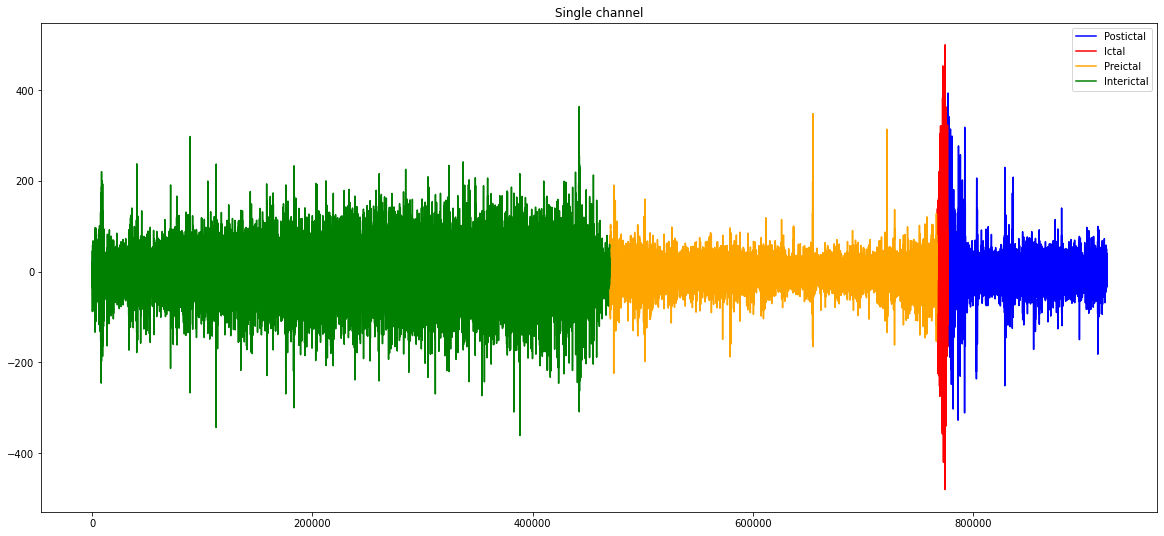

In [ ]:
length = 20 * 60 * 256

ictal_start = 2996 * 256
ictal_end = 3036 * 256

pre_start = ictal_end - length
pre_end = ictal_start

inter_start = 0 #pre_start - length
inter_end = pre_start

ictal_seg = signal[ictal_start : ictal_end]
pre_seg = signal[pre_start : pre_end]
inter_seg = signal[inter_start : inter_end]
after_ictal_seg = signal[ictal_end : ]

# shifting signals to crct position by adding array of zeros to start
pre_seg = np.concatenate([np.zeros(inter_seg.shape), pre_seg])
ictal_seg = np.concatenate([np.zeros(pre_seg.shape), ictal_seg])
after_ictal_seg = np.concatenate([np.zeros(ictal_seg.shape), after_ictal_seg])

plt.figure(figsize = (20, 9))

plt.plot(after_ictal_seg, color = 'blue')
plt.plot(ictal_seg, color = 'red')
plt.plot(pre_seg, color = 'orange')
plt.plot(inter_seg, color = 'green')

plt.title("Single channel")
plt.legend(['Postictal', 'Ictal', 'Preictal', 'Interictal'], loc = 'upper right')
plt.show()

#testing a model

In [ ]:
!pip install  pyentrp
!pip install detecta

  Created wheel for pyentrp: filename=pyentrp-0.6.0-py2.py3-none-any.whl size=5040 sha256=472129d1041afbc5bc94cbef12b2965ef3e702ad80b5e696babb522d31eae308
  Stored in directory: /root/.cache/pip/wheels/44/a7/bf/aa8564feec418eb244eed9cd6cf06aba8e3e3591ee6037e0fd
Successfully built pyentrp


In [ ]:
import random
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy.signal import welch
from pyentrp import entropy as ent
from detecta import detect_peaks

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

In [ ]:
 def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

In [ ]:
def get_first_n_peaks(x,y,no_peaks=5):
  x_, y_ = list(x), list(y)
  if len(x_):
    return x_[:no_peaks], y_[:no_peaks]
  else:
    missing_no_peaks = no_peaks-len(x_)
    return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

In [ ]:
def get_features(x_values, y_values, mph):
  indices_peaks = detect_peaks(y_values, mph=mph)
  peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
  return peaks_x + peaks_y

In [ ]:
#temp
def helper_func(signal, T, fs, N):
  fft_x,fft_y = get_fft_values(signal, T, N, fs)
  psd_x, psd_y = get_psd_values(signal, T, N, fs)  
  autocorr_x, autocorr_y = get_autocorr_values(signal, T, N, fs)  
  
  return (fft_x, fft_y, psd_x, psd_y, autocorr_x, autocorr_y)

In [ ]:
#temp
def get_values_func(data, channel_num, preictal_interval, window_size):
  gap = 10 * 60 * 256
  length = preictal_interval * 60 * 256
  window_size = window_size * 256
  inc = int(window_size / 15)
  data_list = list()
  label_list = list()

  for item in data:    
    files = item[0]
    start_time = item[1] + gap

    if len(files) == 3:
      temp_inter_1 = edf.EdfReader(DOWNLOAD_PATH+files[0]).readSignal(channel_num)
      temp_inter_2 = edf.EdfReader(DOWNLOAD_PATH+files[1]).readSignal(channel_num)
      temp_pre = edf.EdfReader(DOWNLOAD_PATH+files[2]).readSignal(channel_num)[0: start_time*256]    
      sequence = np.concatenate((temp_inter_1, temp_inter_2, temp_pre))
    else:
      temp_inter = edf.EdfReader(DOWNLOAD_PATH+files[0]).readSignal(channel_num)
      temp_pre = edf.EdfReader(DOWNLOAD_PATH+files[1]).readSignal(channel_num)[0: start_time*256]    
      sequence = np.concatenate((temp_inter, temp_pre))

    sequence = filter_signal(sequence)
    signal_length = sequence.shape[0]
    
    interval = preictal_interval * 60 * 256
    pre_start = signal_length - interval
    inter_start = pre_start - interval
    interictal, preictal = sequence[inter_start : pre_start], sequence[pre_start:]
    
    fft_x, fft_y, psd_x, psd_y, auto_x, auto_y = list(), list(), list(), list(), list(), list()
    #features from interictal files
    for i in range(0, interictal.shape[0] - window_size, inc):
      segment = interictal[i : i + window_size]
      features = helper_func(segment, T, F_S, N)      
      fft_x.append(features[0])
      fft_y.append(features[1])
      psd_x.append(features[2])
      psd_y.append(features[3])
      auto_x.append(features[4])
      auto_y.append(features[5])
    
    #features from preictal values
    for i in range(0, preictal.shape[0] - window_size, inc):
      segment = preictal[i : i + window_size]
      features = helper_func(segment, T, F_S, N)      
      

  return np.array(fft_x), np.array(fft_y), np.array(psd_x), np.array(psd_y), np.array(auto_x), np.array(auto_y)

In [ ]:
PATIENT_NUM = 1

#optimal value
CHANNEL_NUM = 10
PREICTAL_INTERVAL_IN_MINS = 30#in mins
SEGMENT_SIZE = 15#in secs

#values for feature extraction
N = SEGMENT_SIZE * 256
T = SEGMENT_SIZE / N
F_S = 256

print(f"Channel num: {CHANNEL_NUM} pre ictal interval: {PREICTAL_INTERVAL_IN_MINS} segment size: {SEGMENT_SIZE}")
fft_x, fft_y, psd_x, psd_y, auto_x, auto_y = get_values_func(files, CHANNEL_NUM, PREICTAL_INTERVAL_IN_MINS, SEGMENT_SIZE)
print("Number of samples:  ", fft_x.shape, psd_x.shape, auto_x.shape)

Channel num: 10 pre ictal interval: 30 segment size: 15
Number of samples:   (1785, 1920) (1785, 129) (1785, 3840)


In [ ]:
df_fftx = pd.DataFrame(fft_x[0:100])
df_ffty = pd.DataFrame(fft_y[0:100])

df_psdx = pd.DataFrame(psd_x[0:100])
df_psdy = pd.DataFrame(psd_y[0:100])

df_autox = pd.DataFrame(auto_x[0:100])
df_autoy = pd.DataFrame(auto_y[0:100])

df_fftx.to_csv('fft_x_values.csv')
df_ffty.to_csv('fft_y_values.csv')
df_psdx.to_csv('psd_x_values.csv')
df_psdy.to_csv('psd_y_values.csv')
df_autox.to_csv('auto_x_values.csv')
df_autoy.to_csv('auto_y_values.csv')

In [ ]:
def extract_features(signal, T, fs, N):
  features = []
  signal_min = np.nanpercentile(signal, 5)
  signal_max = np.nanpercentile(signal, 95)

  mph = signal_min + (signal_max - signal_min)/10

  features += get_features(*get_psd_values(signal, T, N, fs), mph)
  features += get_features(*get_fft_values(signal, T, N, fs), mph)
  features += get_features(*get_autocorr_values(signal, T, N, fs), mph)
  return features

In [ ]:
def accuracy(predictions, y_val):
  true_count  = 0
  for true, pred in zip(y_val,  predictions):
    if(true == pred):
      true_count += 1

  return true_count / len(predictions)

In [ ]:
def process_data_model(data, channel_num, preictal_interval, window_size):
  gap = 10 * 60 * 256
  length = preictal_interval * 60 * 256
  window_size = window_size * 256
  inc = int(window_size / 15)
  data_list = list()
  label_list = list()

  for item in data:    
    files = item[0]
    start_time = item[1] + gap

    if len(files) == 3:
      temp_inter_1 = edf.EdfReader(DOWNLOAD_PATH+files[0]).readSignal(channel_num)
      temp_inter_2 = edf.EdfReader(DOWNLOAD_PATH+files[1]).readSignal(channel_num)
      temp_pre = edf.EdfReader(DOWNLOAD_PATH+files[2]).readSignal(channel_num)[0: start_time*256]    
      sequence = np.concatenate((temp_inter_1, temp_inter_2, temp_pre))
    else:
      temp_inter = edf.EdfReader(DOWNLOAD_PATH+files[0]).readSignal(channel_num)
      temp_pre = edf.EdfReader(DOWNLOAD_PATH+files[1]).readSignal(channel_num)[0: start_time*256]    
      sequence = np.concatenate((temp_inter, temp_pre))

    sequence = filter_signal(sequence)
    signal_length = sequence.shape[0]
    
    interval = preictal_interval * 60 * 256
    pre_start = signal_length - interval
    inter_start = pre_start - interval

    interictal, preictal = sequence[inter_start : pre_start], sequence[pre_start:]

    #features from interictal files
    for i in range(0, interictal.shape[0] - window_size, inc):
      segment = interictal[i : i + window_size]
      features = extract_features(segment, T, F_S, N)      
      data_list.append(features)      
      label_list.append(0)
    
    #features from preictal values
    for i in range(0, preictal.shape[0] - window_size, inc):
      segment = preictal[i : i + window_size]
      features = extract_features(segment, T, F_S, N)      
      data_list.append(features)     
      label_list.append(1)

  #some samples 28 features instead of 30. so fill those samples with zeros
  for sample in data_list:
    while len(sample) < 30:      
      sample.append(0)
    
  return np.asarray(data_list), np.asarray(label_list)

###extract features

In [ ]:
PATIENT_NUM = 1

#optimal value
CHANNEL_NUM = 19
PREICTAL_INTERVAL_IN_MINS = 30#in mins
SEGMENT_SIZE = 15#in secs

#values for feature extraction
N = SEGMENT_SIZE * 256
T = SEGMENT_SIZE / N
F_S = 256

In [ ]:
files

[(['chb01_01.edf', 'chb01_02.edf', 'chb01_03.edf'], 2996),
 (['chb01_13.edf', 'chb01_14.edf', 'chb01_15.edf'], 1732),
 (['chb01_14.edf', 'chb01_15.edf', 'chb01_16.edf'], 1015),
 (['chb01_16.edf', 'chb01_17.edf', 'chb01_18.edf'], 1720),
 (['chb01_24.edf', 'chb01_25.edf', 'chb01_26.edf'], 1862)]

In [ ]:
print(f"Channel num: {CHANNEL_NUM} pre ictal interval: {PREICTAL_INTERVAL_IN_MINS} segment size: {SEGMENT_SIZE}")
x, y = process_data_model(files, CHANNEL_NUM, PREICTAL_INTERVAL_IN_MINS, SEGMENT_SIZE)
print("Number of samples:  ", x.shape)

Channel num: 19 pre ictal interval: 30 segment size: 15
Number of samples:   (17850, 30)


In [ ]:
s_x, s_y = x[0:100], y[0:100]

In [ ]:
data_x = pd.DataFrame(s_x)
data_y = pd.DataFrame(s_y)
data_x.to_csv('Data_x.csv')
data_y.to_csv('Data_y.csv')

In [ ]:
plt.plot(x[0])
plt.show()

In [ ]:
plt.plot(x[5358])
plt.show()

In [ ]:
'''
Interval    Window_size    Samples
10          15             5850
15          15             8850
20          15             11850
25          15             14850
30          15             17850
45          15             26850
60          15             35850
'''

In [ ]:
'''
Reduce the number of samples. 
So that final number of samples will be the same for varying preictal intervals and window size.
The reduced number of samples will contain equal number of preictal and interictal class.
'''

final_size = 17850
n_samples = x.shape[0]

if(n_samples > final_size):
  preictal_index = random.sample(range(0, int(n_samples / 2)), int(final_size / 2))
  interictal_index = random.sample(range(int(n_samples / 2), n_samples), int(final_size / 2))
  index = preictal_index + interictal_index
  x = x[index]
  y = y[index]

In [ ]:
x, y = shuffle(x, y)
x.shape

(21510, 30)

In [ ]:
#random forest
def random_forest(x_train, y_train, x_val, y_val):
  rf_clf = RandomForestClassifier()
  rf_clf.fit(x_train, y_train)

  rf_predictions = rf_clf.predict(x_val)
  fpr = confusion_matrix(y_val, rf_predictions, normalize = 'true')[0][1]
  return accuracy(rf_predictions, y_val), fpr

In [ ]:
#svm
def svc_model(x_train, y_train, x_val, y_val):
  svc_clf = SVC(gamma = 'auto')
  svc_clf.fit(x_train, y_train)

  svc_predictions = svc_clf.predict(x_val)
  fpr = confusion_matrix(y_val, svc_predictions, normalize = 'true')[0][1]
  return accuracy(svc_predictions, y_val), fpr

In [ ]:
#neural net
def neural_net(x_train, y_train, x_val, y_val):
  model = Sequential()
  model.add(Dense(128, input_dim = 30, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.fit(x_train, y_train, epochs = 50, batch_size = 8, verbose = 0)

  nn_predictions = model.predict_classes(x_val)
  nn_predictions = [p[0] for p in nn_predictions]
  fpr = confusion_matrix(y_val, nn_predictions, normalize = 'true')[0][1]
  return accuracy(nn_predictions, y_val), fpr

In [ ]:
#k-fold
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 10)

rf_acc_list, svm_acc_list, nn_acc_list = list(), list(), list()
rf_fpr_list, svm_fpr_list, nn_fpr_list = list(), list(), list()


for train_index, test_index in skf.split(x, y):
  x_train, y_train = x[train_index], y[train_index]
  x_test, y_test = x[test_index], y[test_index]

  scaler = StandardScaler()
  
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  acc, fpr = random_forest(x_train, y_train, x_test, y_test)
  rf_acc_list.append(acc)
  rf_fpr_list.append(fpr)

  acc, fpr = svc_model(x_train, y_train, x_test, y_test)
  svm_acc_list.append(acc)
  svm_fpr_list.append(fpr)

  acc, fpr = neural_net(x_train, y_train, x_test, y_test)
  nn_acc_list.append(acc)
  nn_fpr_list.append(fpr)

print(f"RF  Acc: {np.average(rf_acc_list)} FPR: {np.average(rf_fpr_list)}")
print(f"SMV  Acc: {np.average(svm_acc_list)} FPR: {np.average(svm_fpr_list)}")
print(f"NN  Acc: {np.average(nn_acc_list)} FPR: {np.average(nn_fpr_list)}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

RF  Acc: 0.837238315088445 FPR: 0.19181860290601924
SMV  Acc: 0.6686657469700188 FPR: 0.3950727528599763
NN  Acc: 0.7364016194895923 FPR: 0.2769850769891445


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


##visualize results

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
results = pd.read_csv('stat_model_results.csv')

In [ ]:
results.head()

,Unnamed: 0,Max Difference,Unnamed: 2,Unnamed: 3,Min Difference,Unnamed: 5,Unnamed: 6,optimized results,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Non-optimized results,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,patient,channel num,preictal interval,window size,channel num,preictal interval,window size,RF_ACC,RF_FPR,SVM_ACC,SVM_FPR,NN_ACC,NN_FPR,RF_ACC,RF_FPR,SVM_ACC,SVM_FPR,NN_ACC,NN_FPR
1,1,0,25,15,16,20,10,0.9053,0.07,0.7736,0.19,0.8439,0.17,0.8074,0.19,0.6547,0.35,0.7013,0.29
2,2,6,20,15,11,15,10,0.9182,0.07,0.8116,0.13,0.8443,0.13,0.8887,0.11,0.7278,0.27,0.7726,0.25
3,3,12,15,15,7,30,15,0.8762,0.06,0.7189,0.21,0.7594,0.27,0.8864,0.13,0.6556,0.39,0.7546,0.25
4,4,3,25,15,16,10,10,0.9363,0.07,0.7376,0.3,0.8555,0.15,0.9019,0.07,0.7573,0.1819,0.8516,0.13


In [ ]:
#from results.csv
PATIENT_NUM = 1
opt_rf = float (results['Unnamed: 8'][PATIENT_NUM])
min_rf = float (results['Unnamed: 14'][PATIENT_NUM])
opt_svm = float (results['Unnamed: 10'][PATIENT_NUM])
min_svm = float (results['Unnamed: 16'][PATIENT_NUM])
opt_nn = float (results['Unnamed: 12'][PATIENT_NUM])
min_nn = float (results['Unnamed: 18'][PATIENT_NUM])

In [ ]:
def create_plots(PATIENT_NUM):
  opt_rf = float (results['Unnamed: 8'][PATIENT_NUM])
  min_rf = float (results['Unnamed: 14'][PATIENT_NUM])
  opt_svm = float (results['Unnamed: 10'][PATIENT_NUM])
  min_svm = float (results['Unnamed: 16'][PATIENT_NUM])
  opt_nn = float (results['Unnamed: 12'][PATIENT_NUM])
  min_nn = float (results['Unnamed: 18'][PATIENT_NUM])

  bar_width = 0.25
  fpr_opt = [opt_rf, opt_svm, opt_nn]
  fpr_min = [min_rf, min_svm, min_nn]

  x_opt = [1, 2, 3]
  x_min = [x + bar_width for x in x_opt]

  plt.figure(figsize = (12, 7))
  plt.bar(x_opt, fpr_opt, color='green', width = bar_width, label = "optimized")
  plt.bar(x_min, fpr_min, color = 'orange', width = bar_width, label = "random")

  for i, v in enumerate(fpr_opt):
    plt.text((i+1) - 0.05, v+0.005, str(v))
  for i, v in enumerate(fpr_min):
    plt.text((i+1 + 0.25) - 0.05, v+0.005, str(v))

  plt.legend()
  plt.title(f'Performance(False positive rate) for patient {PATIENT_NUM}')
  plt.xticks([(x+bar_width/2) for x in x_opt],['RF', 'SVM', 'NN'])
  plt.xlabel('Model')
  plt.ylabel('FPR')
  plt.savefig(f'fpr_plot_{PATIENT_NUM}.png', bbox_inches = "tight")
  plt.show()

In [ ]:
for i in range(1, 24, 1):
  create_plots(i)

In [ ]:
plot_dir = "/content/drive/My Drive/chb_dataset/stat_approach/perf_plots/"
for i in range(1, 24, 1):
  sp.call(['mv', f'fpr_plot_{i}.png', plot_dir+f'fpr_plot_{i}.png'])